# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file =   './data/train.p'
validation_file = './data/valid.p'
testing_file =    './data/test.p'

classes_file = 'signnames.csv'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

print('Data loaded.')

Data loaded.


---

## Step 1: Dataset Summary & Exploration



### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import csv 
import random

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
#label_types = {'num': [], 'meaning': [] }
label_list = []
label_index = []
label_names = []

with open(classes_file,'r') as fl:
    reader = csv.reader( fl )
    for row in reader:
        if row[0].isdecimal():
            label_index.append( row[0] )
            label_names.append( row[1] )

label_list = list( zip(label_index, label_names) )


labels_N = len( label_list )            

print("- Image Shape: {}".format(X_train[0].shape))
print()
print("- Training Set:   {:5d} samples".format(len(X_train)))
print("- Validation Set: {:5d} samples".format(len(X_valid)))
print("- Test Set:       {:5d} samples".format(len(X_test)))
print()
print('- There are : {} label types.'.format( labels_N ) )
print('- Example: ' + str( label_list[random.randint(0, labels_N)]) )
print('- Example: ' + str( label_list[random.randint(0, labels_N)]) )


- Image Shape: (32, 32, 3)

- Training Set:   34799 samples
- Validation Set:  4410 samples
- Test Set:       12630 samples

- There are : 43 label types.
- Example: ('35', 'Ahead only')
- Example: ('12', 'Priority road')


### Include an exploratory visualization of the dataset

Below an auxiliary funtion to plot a single image is created, with the possibility of passing the predicted value to be used later. 

I plot some random images for visualization.

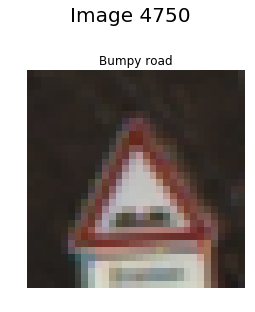

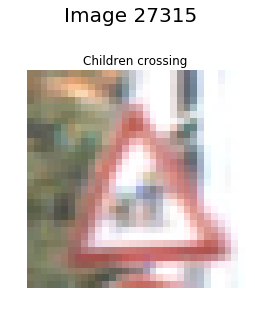

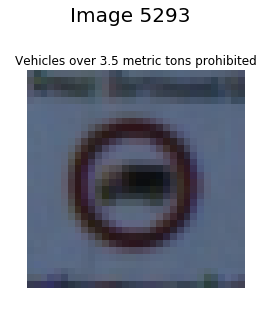

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
%matplotlib inline

def plot_image(image_i,  images, label_ids, prediction = -1):

    image = images[image_i]
    label_id = label_ids[image_i]
    
    fig, axies = plt.subplots(nrows=1, ncols=1)
    
    fig.suptitle('Image '+ str(image_i), fontsize=20, y=1.1)
    
    if prediction == -1:
        correct_name = label_names[label_id]
    else:
        correct_name = 'True: ' + label_names[label_id] + '\nPrediction: ' + label_names[prediction]
        
    axies.imshow(image)
    axies.set_title(correct_name)
    axies.set_axis_off()

index = random.randint(0, len(X_train))
plot_image(index, X_train, y_train)
index = random.randint(0, len(X_train))
plot_image(index, X_train, y_train)
index = random.randint(0, len(X_train))
plot_image(index, X_train, y_train)

Now I calculate for each signal type the proportion that is in the training, validation and test datasets. 
Then plot in bars that distribution to verify that no signal type is too disproportionate between datasets. 
The proportions seem to be fair.

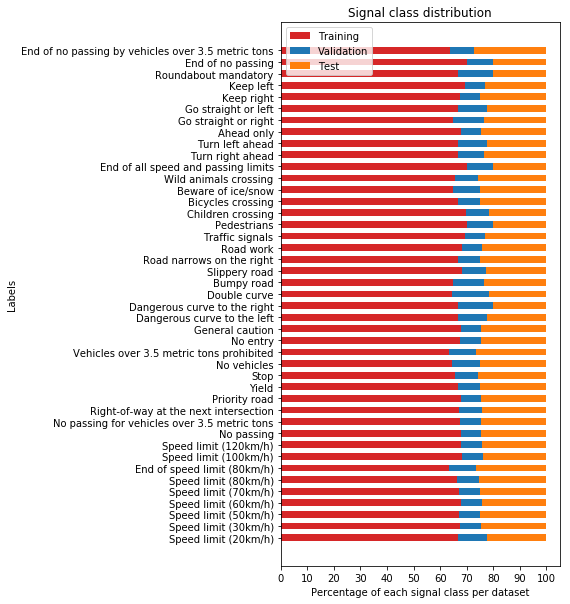

In [4]:

#%% Plot signal class distribution in the train, validation and test datasets
label_ids_in_train = np.zeros( len(label_index) )
label_ids_in_valid = np.zeros( len(label_index) )
label_ids_in_test  = np.zeros( len(label_index) )

unique, counts = np.unique(y_train, return_counts=True)
for index, count in zip(unique, counts):
    label_ids_in_train[index] = count
    
unique, counts = np.unique(y_valid, return_counts=True)
for index, count in zip(unique, counts):
    label_ids_in_valid[index] = count

unique, counts = np.unique(y_test, return_counts=True)
for index, count in zip(unique, counts):
    label_ids_in_test[index] = count
    
for index in range(len(label_index)):
    sum_tot = label_ids_in_train[index] + label_ids_in_valid[index] + label_ids_in_test[index]
    label_ids_in_train[index] = label_ids_in_train[index] / sum_tot * 100.0
    label_ids_in_valid[index] = label_ids_in_valid[index] / sum_tot * 100.0
    label_ids_in_test[index] =  label_ids_in_test[index]  / sum_tot * 100.0
    
ind = np.arange( len(label_index) )    # the x locations for the groups
height = 0.6       # the width of the bars: can also be len(x) sequence

plt.figure(figsize=(5,10))
p1 = plt.barh(ind, label_ids_in_train, height, color='#d62728')
p2 = plt.barh(ind, label_ids_in_valid, height, left= label_ids_in_train)
p3 = plt.barh(ind, label_ids_in_test, height, left= label_ids_in_train+ label_ids_in_valid)

plt.ylabel('Labels')
plt.title('Signal class distribution')
plt.yticks(ind, label_names)
plt.xticks(np.arange(0, 110, 10))
plt.xlabel('Percentage of each signal class per dataset')
plt.legend((p1[0], p2[0], p3[0]), ('Training', 'Validation','Test'))

plt.show()


----

## Step 2: Design and Test a Model Architecture

My starting point is the Lanet used previously in the course. 
I modify some aspects in order to increase the accuracy:

- Increased the number of filters from 6 to 16 in the first layer and 32 in the second.
- I added normalization to the inputs and to the output of the convolution layers.
- Use of dropout.


### Pre-process the Data Set (normalization, grayscale, etc.)

The input data is normalized in the network (next paragraph) with the batch_norm layer.

### Model Architecture

In [5]:
### Define your architecture here.
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for 
    # the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Normalize input
    x = tf.contrib.layers.batch_norm( x, is_training = True)
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x16.
    # Shape of the filter-weights for the convolution.
    c1_layers = 16
    c1_s = [5, 5, 3, c1_layers]

    # Create new weights and bias
    c1_w = tf.Variable( tf.truncated_normal(c1_s, mean = mu, stddev = sigma), name = 'c1_w' )
    c1_b = tf.Variable( tf.zeros(c1_layers), name = 'c1_b' )

    # Create the TensorFlow operation for convolution.
    c1 = tf.nn.conv2d(  input = x,
                        filter = c1_w,
                        strides = [1, 1, 1, 1],
                        padding = 'VALID')
    c1 = tf.nn.bias_add( c1, c1_b)

    # Pooling. Input = 28x28x16. Output = 14x14x16.
    c1 = tf.nn.max_pool(    value =   c1,
                            ksize =   [1, 2, 2, 1],
                            strides = [1, 2, 2, 1],
                            padding = 'SAME')
    # Activation.
    c1 = tf.nn.relu( c1 )
    c1 = tf.contrib.layers.batch_norm( c1, is_training = True)
    

    # Layer 2: Convolutional. Output = 10x10x32.
    # Shape of the filter-weights for the convolution.
    c2_layers = 32
    c2_s = [5, 5, c1_layers, c2_layers]

    # Create new weights and bias
    c2_w = tf.Variable( tf.truncated_normal(c2_s, mean = mu, stddev = sigma), name = 'c2_w' )
    c2_b = tf.Variable( tf.zeros( c2_layers ), name = 'c2_b' )

    # Create the TensorFlow operation for convolution.
    c2 = tf.nn.conv2d(  input = c1,
                        filter = c2_w,
                        strides = [1, 1, 1, 1],
                        padding = 'VALID')
    c2 = tf.nn.bias_add( c2, c2_b)

    # Pooling. Input = 10x10x32. Output = 5x5x32.
    c2 = tf.nn.max_pool(    value =   c2,
                            ksize =   [1, 2, 2, 1],
                            strides = [1, 2, 2, 1],
                            padding = 'SAME')
    # Activation.
    c2 = tf.nn.relu( c2 )
    c2 = tf.contrib.layers.batch_norm( c2, is_training = True)

    # Flatten. Input = 5x5x32. Output = 800.
    flat = flatten( c2 )
    
    # Layer 3: Fully Connected. Input = 800. Output = 120.
    fc1_s = ( c2_s[0] * c2_s[1] * c2_s[3], 120)
    fc1_w = tf.Variable( tf.truncated_normal(fc1_s, mean = mu, stddev = sigma), name = 'fc1_w' )
    fc1_b = tf.Variable( tf.zeros(120), name = 'fc1_b' )
    fc1 = tf.add( tf.matmul( flat, fc1_w ), fc1_b)
    
    fc1 = tf.nn.relu( fc1 )
    fc1 = tf.nn.dropout( fc1, keep_prob )
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_s = (120, 84)
    fc2_w = tf.Variable( tf.truncated_normal(fc2_s, mean = mu, stddev = sigma), name = 'fc2_w' )
    fc2_b = tf.Variable( tf.zeros(84), name = 'fc2_b' )
    fc2 = tf.add( tf.matmul( fc1, fc2_w ), fc2_b)
    
    fc2 = tf.nn.relu( fc2 )
    fc2 = tf.nn.dropout( fc2, keep_prob )
    
    # Layer 5: Fully Connected. Input = 84. Output = labels_N.
    fc3_s = (84, labels_N)
    fc3_w = tf.Variable( tf.truncated_normal(fc3_s, mean = mu, stddev = sigma), name = 'fc3_w' )
    fc3_b = tf.Variable( tf.zeros(labels_N), name = 'fc3_b' )
    logits = tf.add( tf.matmul( fc2, fc3_w ), fc3_b)
    
    return logits, c1, c2

# Inputs
x = tf.placeholder(tf.float32, (None, 32, 32, 3), name = 'x')
y = tf.placeholder(tf.int32, (None), name = 'y')
one_hot_y = tf.one_hot(y, labels_N, name = 'one_hot_y')
keep_prob = tf.placeholder(tf.float32, name = 'keep_prob')

# Network, cost function, optimizer.
rate = 0.001
logits, c1, c2 = LeNet( x, keep_prob )
cross_entropy = tf.nn.softmax_cross_entropy_with_logits( logits = logits, labels = one_hot_y )
predictions = tf.nn.softmax( logits )
loss_operation = tf.reduce_mean( cross_entropy )
optimizer = tf.train.AdamOptimizer( learning_rate = rate, name = 'optimizer' )
training_operation = optimizer.minimize( loss_operation, name = 'training_operation' )


### Evaluation function 
Funtion to check the accuracy of the network to some given input.

In [6]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data, BATCH_SIZE):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
        
    return total_accuracy / num_examples

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [7]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

EPOCHS = 10
BATCH_SIZE = 128*2
# Dropout keep probability 
keep_prob_input = 0.5
from sklearn.utils import shuffle

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: keep_prob_input})
            
        validation_accuracy = evaluate(X_valid, y_valid, BATCH_SIZE)
        training_accuracy = evaluate(X_train, y_train, BATCH_SIZE)
        print("EPOCH {} - Training accuracy = {:.1%} / Validation Accuracy = {:.1%}".format(i+1, training_accuracy, validation_accuracy))
        
    saver.save(sess, './lenet')
    print("Model saved")
    print()


Training...

EPOCH 1 - Training accuracy = 62.1% / Validation Accuracy = 52.8%
EPOCH 2 - Training accuracy = 84.8% / Validation Accuracy = 76.2%
EPOCH 3 - Training accuracy = 93.7% / Validation Accuracy = 85.1%
EPOCH 4 - Training accuracy = 96.6% / Validation Accuracy = 89.4%
EPOCH 5 - Training accuracy = 97.4% / Validation Accuracy = 91.6%
EPOCH 6 - Training accuracy = 98.4% / Validation Accuracy = 93.2%
EPOCH 7 - Training accuracy = 98.8% / Validation Accuracy = 93.5%
EPOCH 8 - Training accuracy = 99.0% / Validation Accuracy = 93.4%
EPOCH 9 - Training accuracy = 99.3% / Validation Accuracy = 93.8%
EPOCH 10 - Training accuracy = 99.4% / Validation Accuracy = 95.2%
Model saved



### Test accuracy
The accuracy is now tested in an independent set of samples not used during training.

In [8]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test, BATCH_SIZE)
    print("Test Accuracy = {:.1%}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from .\lenet
Test Accuracy = 94.2%


### Show result on some images from the test batch

INFO:tensorflow:Restoring parameters from ./lenet


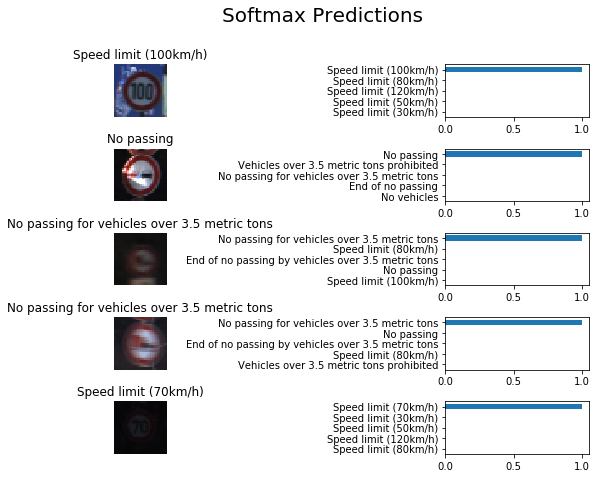

In [9]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

n_samples = 5
top_n_predictions = 5
saver = tf.train.Saver()
# Pick some random images from the test batch.
predict_feature, real_outputs, real_labels = tuple(zip(*random.sample(list(zip(X_test, y_test, [label_names[x] for x in y_test])), n_samples)))

with tf.Session() as sess:
    saver.restore(sess, './lenet')
    predicted = sess.run( tf.nn.top_k(tf.nn.softmax(logits), top_n_predictions), feed_dict= { x: predict_feature, keep_prob: 1.0 } )
    
def display_image_predictions(images, real_labels, predicted):

    fig, axies = plt.subplots(figsize=(8, 6),nrows=n_samples, ncols=3)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = top_n_predictions
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (image, label_id, pred_indicies, pred_values) in enumerate(zip(images, real_labels, predicted.indices, predicted.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]
        
        axies[image_i][0].imshow(image)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()
        
        axies[image_i][1].set_axis_off()

        axies[image_i][2].barh(ind + margin, pred_values[::-1], width*3)
        axies[image_i][2].set_yticks(ind + margin)
        axies[image_i][2].set_yticklabels(pred_names[::-1])
        axies[image_i][2].set_xticks([0, 0.5, 1.0])

    
# Print prediction of the random samples
display_image_predictions(predict_feature, real_outputs, predicted)




---

## Step 3: Test a Model on New Images


### Load and Output the Images

The following code will get the indicated n_samples from the folder where the dataset from the website has been downloaded, the "German Traffic Sign Recognition Benchmark" in this case. 

It is not necessary to run this code, but if desired, the [dataset](http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Training_Images.zip) must be downloaded and "folder_images" made equal to the folder where it is decompressed and the images can be found. Then, where there is "if 0:", replace the 0 by a 1 and run the cell.

5 samples have been read and stored in a pickle file which is available in the repository to be used in the cells below the next one.

In [10]:
if 0:
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib.image as mpimg
    import os

    folder_images = r'.\GTSRB\Final_Training\Images'
    filenames = []
    images = []
    labels = []

    # Get 5 random images
    n_samples = 5

    for im_type in np.random.randint(labels_N, size=(n_samples)):

        files = os.listdir(folder_images + r'\000{:02d}'.format(im_type) ) 
        filename = folder_images + r'\000{:02d}\\'.format(im_type) + files[np.random.randint(len(files)-1)]
        print(filename)
        filenames.append(filename)
        image = mpimg.imread(filename)
        images.append(image)
        labels.append(im_type)
        plt.figure
        plt.imshow(image)
        plt.show()

    filename = 'new_images.p'
    pickle.dump((images, labels), open(filename, 'wb'))

### Predict the Sign Type for Each Image and Output Top 5 Softmax Probabilities For Each Image Found on the Web

5 stored images with their label id are stored in the pickle file "new_images.p". The file is loaded, the network applied and the results plot.

INFO:tensorflow:Restoring parameters from ./lenet


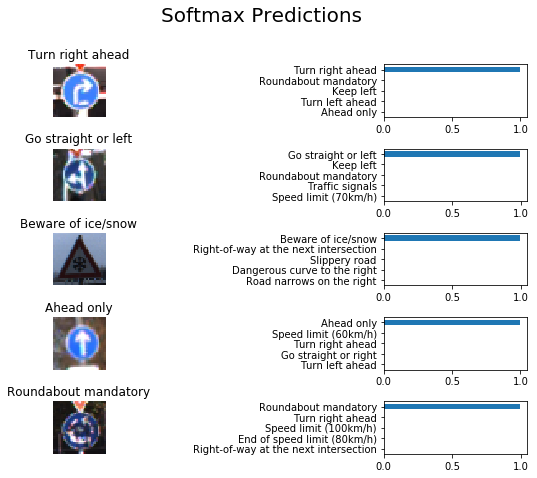

In [11]:
import cv2
# Train with images from the internet.

# Load stored new images
new_images, new_labels = pickle.load( open('new_images.p', mode='rb') )

# Preprocess them to fit in the network.
for ind,image in enumerate(new_images):
    image = cv2.resize(image, (32, 32))
    new_images[ind] = image

n_samples = 5
top_n_predictions = 5
saver = tf.train.Saver()
# Pick some random images from the test batch.
new_images, new_labels
with tf.Session() as sess:
    saver.restore(sess, './lenet')
    predicted = sess.run( tf.nn.top_k(tf.nn.softmax(logits), top_n_predictions), feed_dict= { x: new_images, keep_prob: 1.0 } )

# Print prediction of the random samples
display_image_predictions(new_images, new_labels, predicted)

### Analyze Performance

The accuracy for this small set of 5 samples is calculated.

In [12]:
test_accuracy = 0
pred_max_ind = np.argmax(predicted.values, axis=1)
pred_indices = []
for ind in range(5):
    pred_val = predicted.indices[ind][pred_max_ind[ind]]
    if(pred_val == new_labels[ind]):
        test_accuracy += 1
test_accuracy /= 5        
print('Accuracy for the 5 examples run = {}%'.format(test_accuracy*100))


Accuracy for the 5 examples run = 100.0%


## Step 4: Visualize the Neural Network's State with Test Images
Below the modified code to represent the convolutional output layers and the image processed.

INFO:tensorflow:Restoring parameters from .\lenet


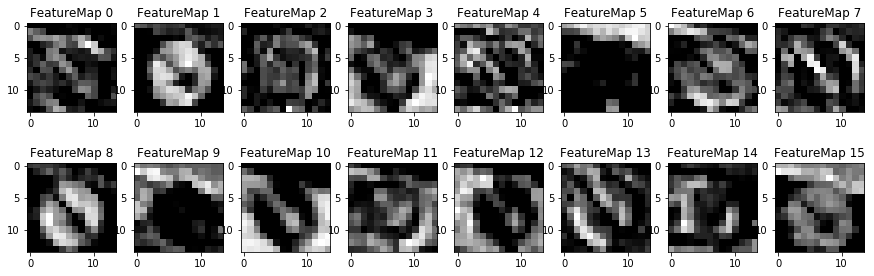

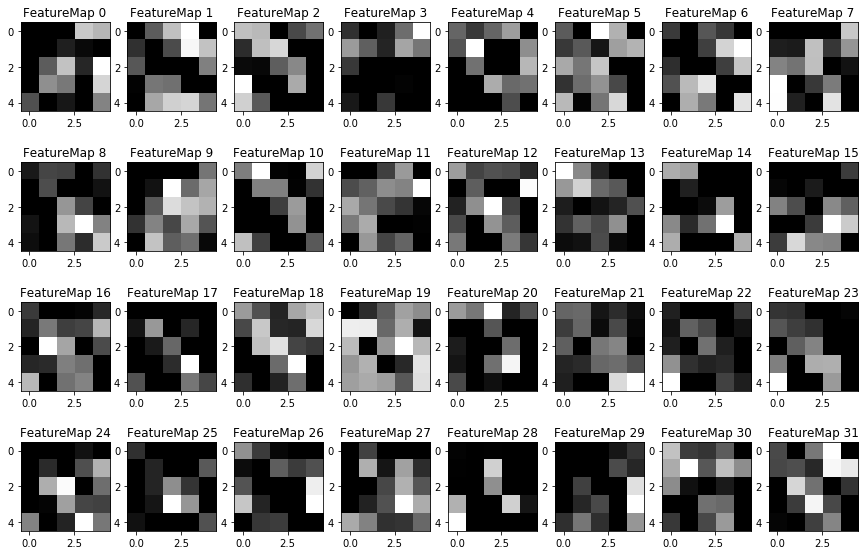

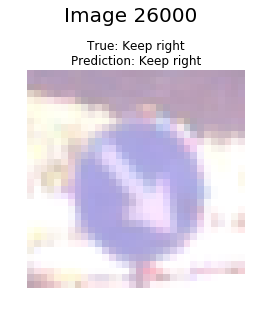

In [13]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure 
#               that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, 
#                   by default matplot sets min and max to the actual min and max 
#                   values of the output
# plt_num: used to plot out multiple different weight feature map sets on the 
#           same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval( session = sess, feed_dict = {x : image_input} )
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
    plt.show()

with tf.Session() as sess:
    index = 26000
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predicted = sess.run( tf.nn.top_k(tf.nn.softmax(logits), 1), feed_dict= { x: X_train[index].reshape([1,32,32,3]), keep_prob: 1.0 } )
    outputFeatureMap(X_train[index].reshape([1,32,32,3]), c1,plt_num=101)
    outputFeatureMap(X_train[index].reshape([1,32,32,3]), c2,plt_num=102)
    plot_image(index, X_train, y_train, predicted.indices[0][0])


### Question 9

**Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images**

Watching the feature maps for the first time made me think that the first layer was not big enough (6 filters), as we have over 40 signals to differentiate. I increased it to 16 obtaining a good accuracy.

The second layer is less helpful since it is a more abstract layer. 
